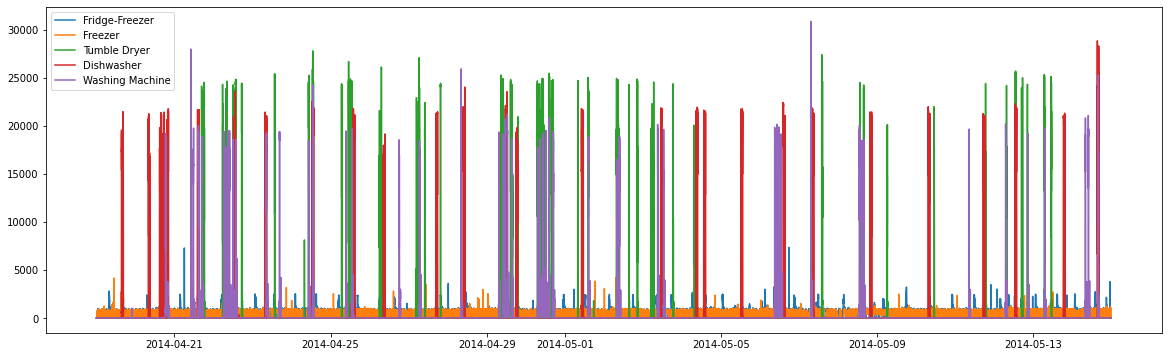

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import stumpy
from stumpy import core
from stumpy.mmotifs import mmotifs

plt.style.use(
    "https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle"
)

start_date, end_date = "2014-04-19", "2014-05-15"
df = pd.read_csv("../CLEAN_House3.csv")
df["Time"] = pd.to_datetime(df["Time"])
colnames = {
    "Appliance1": "Toaster",
    "Appliance2": "Fridge-Freezer",
    "Appliance3": "Freezer",
    "Appliance4": "Tumble Dryer",
    "Appliance5": "Dishwasher",
    "Appliance6": "Washing Machine",
    "Appliance7": "Television",
    "Appliance8": "Microwave",
    "Appliance9": "Kettle",
}
df = (
    df.rename(colnames, axis="columns")
    .loc[
        :,
        [
            "Time",
            "Fridge-Freezer",
            "Freezer",
            "Tumble Dryer",
            "Dishwasher",
            "Washing Machine",
        ],
    ]
    .query("Time >= @start_date and Time <= @end_date")
    .groupby(pd.Grouper(key="Time", freq="T"))
    .sum()
)

for colname in df.columns:
    plt.plot(df[colname], label=colname)
    plt.legend()

Eliminate constant regions

In [5]:
# m was set to 4 hours
m = 4 * 60

for i in range(df.shape[1]):
    # zero_idx = np.flatnonzero(np.sum(core.rolling_window(df.values[:, i], m), axis=1) == 0.0)
    # constant_idx = np.flatnonzero(core.rolling_nanstd(df.values[:, i], m) == 0.0)  # Constant regions will have a 0.0 stddev
    # df.values[:, constant_idx] = np.nan
    
    series = df.values[:, i]
    # Compute rolling mean and standard deviation
    _, mean, stand_dev = core.preprocess(series.astype(float), m)
    # Fill first 'num_points'-1 values (values are NaN when computing the rolling average/mean)
    nan_array = np.empty(m - 1)
    nan_array[:] = np.nan
    mean = np.concatenate((nan_array, mean))
    stand_dev = np.concatenate((nan_array, stand_dev))
    
    constant_idx = np.where(stand_dev == 0.0)  # Constant regions will have a 0.0 stddev
    if len(constant_idx[0]) > 0:
        series.astype(float)[constant_idx[0]] = np.nan
    if stand_dev[m] == 0:
    df.values[:, i].astype(float)[:m] = np.nan

Compute the mutli-dimensional matrix profile

Notice: Each row of the array corresponds to each MP for a given dimension --> first row: 1D MP, second: 2D MP

In [6]:
mps, indices = stumpy.mstump(df.astype(float), m)

Find the multidimensional motif pair

In [7]:
motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls = mmotifs(
    df.astype(float), mps, indices, max_distance=np.inf, max_matches=2
)

Visualize the motif pair

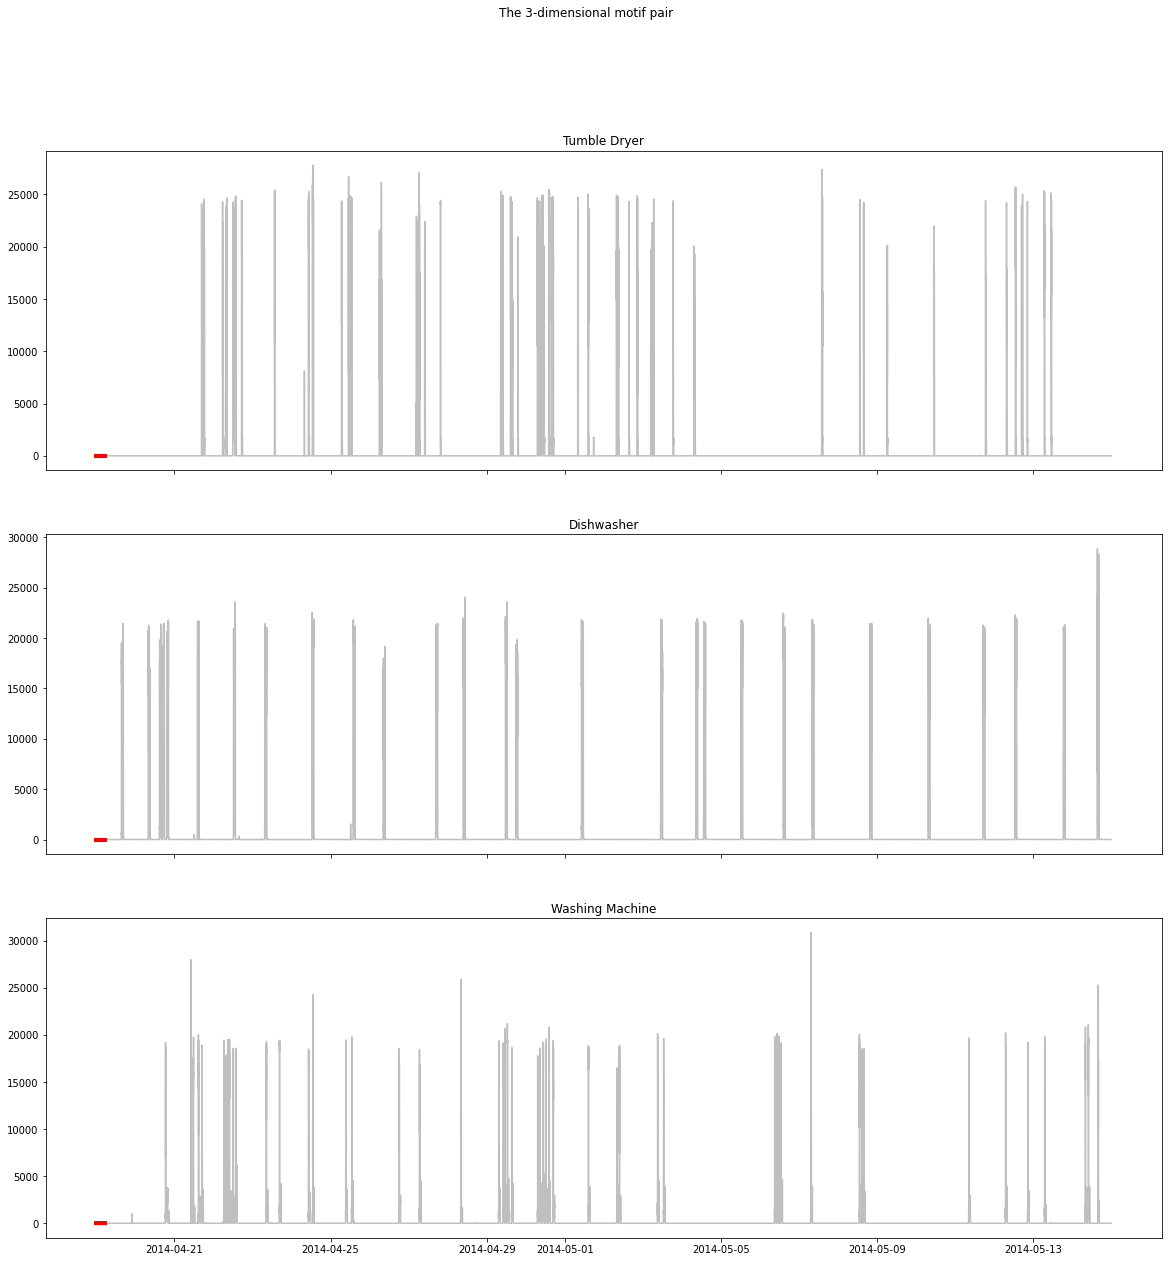

In [8]:
num_motifs = motifs_distances.shape[0]

for motif_num in range(num_motifs):
    motif_indices = motifs_indices[motif_num]
    mdl = motifs_mdls[motif_num]
    S = motifs_subspaces[motif_num]
    subspace = [df.columns.values[s] for s in S]

    k = len(S)
    f, axs = plt.subplots(k, 1, figsize=(20, 20), sharex=True)
    plt.suptitle(f"The {k}-dimensional motif pair")

    for j, s in enumerate(S):
        time_series = df[df.columns[s]]
        if k > 1:
            ax = axs[j]
        else:
            ax = axs
        ax.plot(time_series, c="0.75")
        ax.set_title(df.columns.values[s])

        motif_idx = motif_indices[0]
        nn_idx = motif_indices[1]
        ax.plot(time_series[motif_idx : motif_idx + m], c="r", linewidth=4)
        ax.plot(time_series[nn_idx : nn_idx + m], c="r", linewidth=4)
        # ax.axvline(x=motif_idx, linestyle='dashed', c='k', linewidth=2)
        # ax.axvline(x=nn_idx, linestyle='dashed', c='k', linewidth=2)

        # Only relevant if you want to find further matches
        # Set motif_indices[2:] to avoid double counting the motif pair
        [ax.plot(time_series[match : match + m]) for match in motif_indices[2:]]

Plot MDL ...